In [ ]:
# default_exp models.tcn.tcn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import copy
import os
import random
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.models.tcn.tcn_model import TCNModule
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss

In [ ]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class TCN(object):
    """
    Future documentation
    """

    def __init__(self,
                 output_size,
                 n_channels,
                 kernel_size,
                 initialization,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 dropout_prob,
                 n_iterations,
                 early_stopping,
                 loss,
                 val_loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(TCN, self).__init__()

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.output_size = output_size
        self.initialization = initialization
        self.n_channels = n_channels
        self.kernel_size = kernel_size

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.val_loss = val_loss
        self.dropout_prob = dropout_prob

        # Other
        self.frequency = frequency
        self.seasonality = seasonality
        self.random_seed = random_seed

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def __loss_fn(self, loss_name: str):
        def loss(x, freq, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=freq, mask=mask)
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        #TODO: mas opciones que mae
        self.model.eval()

        losses = []
        with t.no_grad():
            for batch in iter(ts_loader):
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x=insample_x,
                                      outsample_x=outsample_x, s_matrix=s_matrix)

                batch_loss = validation_loss_fn(target=forecast.cpu().data.numpy(),
                                                forecast=outsample_y.cpu().data.numpy(),
                                                weights=outsample_mask.cpu().data.numpy())
                losses.append(batch_loss)
        loss = np.mean(losses)
        self.model.train()
        return loss

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_freq=1):
        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            self.model = TCNModule(output_size=self.output_size, num_inputs = self.n_x_t+1,
                                   num_channels=self.n_channels, num_static = self.n_s,
                                   kernel_size=self.kernel_size, dropout=self.dropout_prob)
            init_function = partial(init_weights, initialization=self.initialization)
            self.model.apply(init_function)
            self.model = self.model.to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        print('\n')
        print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast = self.model(insample_y=insample_y, insample_x=insample_x, outsample_x=outsample_x,
                                      s_matrix=s_matrix)

                training_loss = training_loss_fn(x=insample_y, freq=self.seasonality, forecast=forecast,
                                                target=outsample_y, mask=outsample_mask)

                if not np.isnan(float(training_loss)):
                    training_loss.backward()
                    t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                else:
                    early_stopping_counter = self.early_stopping

                lr_scheduler.step()
                if (iteration % eval_freq == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                            time.time()-start,
                                                                                            self.loss,
                                                                                            training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(training_loss.cpu().data.numpy())

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = copy.deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                    self.model.train()

                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations >0:
            # This is batch loss!
            self.final_insample_loss = training_loss.cpu().data.numpy() if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, X_test=None, eval_mode=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'
        
        forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x=insample_x,
                                      outsample_x=outsample_x, s_matrix=s_matrix)
                forecasts.append(forecast.cpu().data.numpy())
                outsample_ys.append(batch['outsample_y'])
                outsample_masks.append(batch['outsample_mask'])

        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        # Reshape
        n_series = ts_loader.ts_dataset.n_series
        n_fcds = len(outsample_ys) // n_series
        outsample_ys = outsample_ys.reshape(n_series, n_fcds, self.output_size)
        forecasts = forecasts.reshape(n_series, n_fcds, self.output_size)
        outsample_masks = outsample_masks.reshape(n_series, n_fcds, self.output_size)

        self.model.train()
        if eval_mode:
            return outsample_ys, forecasts, outsample_masks
        else:
            assert 1<0, 'mode_eval=False not implemented yet'
        
        return Y_hat_panel


    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# TEST

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
mc = {# Architecture parameters
      'model': 'tcn',
      'input_size_multiplier': 7,
      'output_size': 24,
      'kernel_size': 3,
      'n_channels': [5, 5, 5, 5],
      'initialization': 'lecun_normal',
      'learning_rate': 0.01,
      'lr_decay': 0.5,
      'n_lr_decay_steps': 3,
      'weight_decay': 0,
      'dropout_prob': 0.2,
      'n_iterations': 30,#_000,
      'early_stopping': 10,
      'loss': 'MAE',
      'val_loss': 'MAE',
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'batch_size': 256,
      'window_sampling_limit': 500_000,
      'complete_inputs': False,
      'frequency': 'H',
      'idx_to_sample_freq': 24,
      'random_seed': 1,
      'seasonality': 24,
      'random_seed': 10}

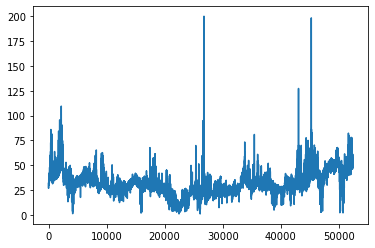

In [ ]:
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsloader_general import TimeSeriesLoader
from nixtla.experiments.utils import create_datasets
import matplotlib.pyplot as plt

dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=dataset)

plt.plot(Y_df.y.values)
plt.show()

In [ ]:
train_ts_dataset, outsample_ts_dataset, scaler_y = create_datasets(mc, Y_df, X_df, S_df, 728*24, False)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=33.33, 	17472.0 time 

In [ ]:
train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                    model='tcn',
                                    window_sampling_limit=int(mc['window_sampling_limit']),
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                    batch_size=int(mc['batch_size']),
                                    complete_inputs=mc['complete_inputs'],
                                    complete_sample=False,
                                    shuffle=True)

val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                 model='tcn',
                                 window_sampling_limit=int(mc['window_sampling_limit']),
                                 input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                 output_size=int(mc['output_size']),
                                 idx_to_sample_freq=24,
                                 batch_size=int(mc['batch_size']),
                                 complete_inputs=False,
                                 complete_sample=False,
                                 shuffle=False)

In [ ]:
model = TCN(output_size=mc['output_size'],
            n_channels=mc['n_channels'],
            kernel_size=mc['kernel_size'],
            initialization=mc['initialization'],
            learning_rate=mc['learning_rate'],
            lr_decay=mc['lr_decay'],
            n_lr_decay_steps=mc['n_lr_decay_steps'],
            weight_decay=mc['weight_decay'],
            dropout_prob=mc['dropout_prob'],
            n_iterations=mc['n_iterations'],
            early_stopping=mc['early_stopping'],
            loss=mc['loss'],
            val_loss=mc['val_loss'],
            frequency=mc['frequency'],
            random_seed=mc['random_seed'],
            seasonality=mc['seasonality'],
            device=None)

In [ ]:
model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, verbose=True, eval_freq=10)



============================== Start fitting ==============================
Step: 10, Time: 0.364, Insample MAE: 8.02221, Outsample MAE: 11.56888
Step: 20, Time: 0.717, Insample MAE: 6.33339, Outsample MAE: 9.73540
Step: 30, Time: 1.047, Insample MAE: 6.13940, Outsample MAE: 4.61914
Step: 30, Time: 1.072, Insample MAE: 6.13940, Outsample MAE: 4.61914
==============================  End fitting  ==============================




In [ ]:
y_true_split, y_hat_split, mask_split = model.predict(ts_loader=val_ts_loader, eval_mode=True)

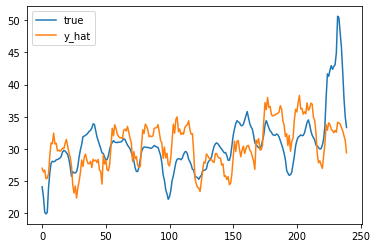

In [ ]:
plt.plot(y_true_split[0, 0:10, :].flatten(), label='true')
plt.plot(y_hat_split[0, 0:10, :].flatten(), label='y_hat')
plt.legend()